# The Art of Description: Evaluating Human and AI Textual Annotations in Gesture Recognition

This Jupyter Notebook presents a comprehensive statistical analysis comparing the quality of hand gesture annotations from humans and large language models (LLMs). These annotations provide textual descriptions of hand gestures designed to enable participants to interact with unified communication platforms solely through hand gestures.

## Background and Context

We tasked participants to perform specific hand gestures to activate commands on Microsoft Teams. These commands allow seamless interaction in various scenarios using only gestures. The study focuses on the following eight commands and their corresponding textual descriptions:

- Increase volume (`c1_description`)
- Decrease volume (`c2_description`)
- Mute microphone (`c3_description`)
- Unmute microphone (`c4_description`)
- Turn off camera (`c5_description`)
- Turn on camera (`c6_description`)
- Ask a question (`c7_description`)
- End call (`c8_description`)

## Objectives

The primary objectives of this analysis are:

- To measure the quality of textual descriptions in terms of `semantic similarity`.
- To evaluate how well textual descriptions enable correct hand gesture command recognition across the Unified Communication Platform context.

## Annotation Process and Dataset Description

To evaluate hand gesture annotations, we categorized our dataset into multiple annotation groups based on the method and source of annotation. Below is a detailed breakdown of the annotation process:

1. **Human Annotations**
    
    We first annotated the dataset by two groups of humans:

- **Human Structured:**
This group consisted of one HCI-expert and two trained human annotators who followed a systematic protocol to annotate the hand gestures. _Dataset file_: ([d0_human_structured_descriptions.csv](data/descriptions/d0_human_structured_descriptions.csv))

- **Human Non-Structured:**
This group included two trained annotators who annotated the dataset collaboratively, without following a predefined protocol. _Dataset file_: ([d1_human_non_structured_descriptions.csv](data/descriptions/d1_human_non_structured_descriptions.csv))

2. **Automated LLM Annotations**

    Next, we used the OpenAI ChatGPT-4o model to generate annotations automatically. We extracted a sequence of images from each video recorded during the experiments. We provided these image sequences to OpenAI ChatGPT-4o to produce the annotations.

- **LLM Structured:**
Annotations generated using the OpenAI ChatGPT-4o model from the image sequences following a systematic protocol to annotate the hand gestures. _Dataset file_: ([d2_openai_structured_descriptions.csv](data/descriptions/d2_openai_structured_descriptions.csv))

- **LLM Non-Structured:**
Annotations generated using the OpenAI ChatGPT-4o model from the image sequences without following a predefined protocol. _Dataset file_: ([d3_openai_non_structured_descriptions.csv](data/descriptions/d3_openai_non_structured_descriptions.csv))

3. **Static Hand State Descriptions and Landmark Extraction**

    For further analysis, we incorporated static hand state descriptions and 3D hand landmark data:

- **Static Hand State Descriptions:**
Following the method introduced by [Zeng et al. (2024)](https://doi.org/10.1145/3698145), we defined hand poses based on:
    - Finger flexion
    - Finger proximity
    - Thumb contact
    - Palm orientation

    These descriptions were derived from the same images used for GPT-4o annotations.

- **Landmark Keypoint Localization:**
Using the [Google MediaPipe Hands model](https://mediapipe.readthedocs.io/en/latest/solutions/hands.html), we extracted the 3D coordinates of 21 hand-knuckle landmarks from the same images. This data is provided in JSON format.

From this process, we created three additional annotation groups:

- **LLM Poses:**
Annotations derived from static hand state descriptions. _Dataset file_: ([d4_openai_poses_descriptions.csv](data/descriptions/d4_openai_poses_descriptions.csv))

- **LLM Landmarks:**
Annotations based on the landmark data extracted using the MediaPipe model. _Dataset file_: ([d5_openai_landmarks_descriptions.csv](data/descriptions/d5_openai_landmarks_descriptions.csv))

- **LLM Combined:**
A combined dataset that integrates both static hand state descriptions and landmark data. _Dataset file_: ([d6_openai_combined_descriptions.csv](data/descriptions/d6_openai_combined_descriptions.csv))

## Setting Up the Environment for Statistical Analysis and Visualization

This section initializes the libraries and configurations required for data analysis and visualization. The following tasks are performed:

- **Importing Libraries:**  
  - Libraries such as `pandas` and `numpy` are loaded for data manipulation.  
  - `matplotlib` and `seaborn` are imported for creating high-quality plots.  
  - `sentence_transformers.util` is used for advanced text similarity computations.  
  - Statistical libraries, including `scipy` and `statsmodels`, are imported to conduct hypothesis testing and statistical comparisons.  

- **Configuring Plot Styles:**  
  - The plotting style is customized to use LaTeX for text rendering (`text.usetex`) and a serif font for professional-quality visualizations.  
  - Mathematical notation is enabled for axis labels and annotations.  

These steps ensure that the analysis environment is fully equipped for statistical computations and the production of publication-ready plots.

In [1]:
# Import necessary libraries.
from enum import Enum
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bert_score import score
from scipy.stats import chi2_contingency, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest


# Set the style of the plots.
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family" : "serif",
    "font.size": 22,
    "font.serif":  "cmr10",
    "text.usetex": True,
    "pgf.rcfonts": False,
})
plt.rcParams["axes.formatter.use_mathtext"] = True

## Defining Enums and Readable Mappings for Hand Gestures and Description Groups

This section introduces `Enum` classes and mappings to manage gestures and annotation groups in a structured and intuitive manner. By using enums, the code ensures type safety and avoids errors associated with hardcoded strings.

### 1. Enum Definitions
- **`Gesture`:**
  Enumerates the set of gesture commands, each corresponding to a specific action.
  Examples: `C1_COMMAND` (Increase volume), `C3_COMMAND` (Mute microphone).

- **`Group`:**
  Enumerates the annotation groups, categorizing data by annotation source or methodology.
  Examples: `HUMAN` (human-generated annotations), `LLM` (LLM-generated annotations).

### 2. Mappings for Readability
Mappings are provided to translate enums into human-readable labels for better interpretation during data analysis and visualization.

- **`GESTURES_MAP`:**
  Maps each gesture to a descriptive label (e.g., `Gesture.C1_COMMAND` -> "Increase volume").

- **`GROUPS_MAP`:**
  Maps each group to a readable label (e.g., `Group.HUMAN_STRUCTURED` -> "Human-S").

### Benefits
Using enums and mappings:
- Reduces the risk of inconsistencies caused by hardcoded strings.
- Improves the clarity and maintainability of the code.
- Enables seamless integration of meaningful labels in the analysis and visualization steps.

In [2]:
class Gesture(Enum):
    """Enum class to represent the different hand gestures."""
    C1_COMMAND = "c1_command"
    C2_COMMAND = "c2_command"
    C3_COMMAND = "c3_command"
    C4_COMMAND = "c4_command"
    C5_COMMAND = "c5_command"
    C6_COMMAND = "c6_command"
    C7_COMMAND = "c7_command"
    C8_COMMAND = "c8_command"

class Group(Enum):
    """Enum class to represent the different description groups."""
    HUMAN_STRUCTURED = "d0_human_structured"
    HUMAN_NON_STRUCTURED = "d1_human_non_structured"
    LLM_STRUCTURED = "d2_openai_structured"
    LLM_NON_STRUCTURED = "d3_openai_non_structured"
    LLM_POSES = "d4_openai_poses"
    LLM_LANDMARKS = "d5_openai_landmarks"
    LLM_COMBINED = "d6_openai_combined"

# Mappings for better readability.
GESTURES_MAP: Dict[Gesture, str] = {
    Gesture.C1_COMMAND: "Increase volume",
    Gesture.C2_COMMAND: "Decrease volume",
    Gesture.C3_COMMAND: "Mute microphone",
    Gesture.C4_COMMAND: "Unmute microphone",
    Gesture.C5_COMMAND: "Turn off camera",
    Gesture.C6_COMMAND: "Turn on camera",
    Gesture.C7_COMMAND: "Ask for a question",
    Gesture.C8_COMMAND: "End call",
}

GROUPS_MAP: Dict[Group, str] = {
    Group.HUMAN_STRUCTURED: "Human-S",
    Group.HUMAN_NON_STRUCTURED: "Human-NS",
    Group.LLM_STRUCTURED: "LLM-S",
    Group.LLM_NON_STRUCTURED: "LLM-NS",
    Group.LLM_POSES: "LLM-HP",
    Group.LLM_LANDMARKS: "LLM-LDMK",
    Group.LLM_COMBINED: "LLM-COMB",
}

## Loading and Preprocessing Gesture Description Datasets

This section performs the following steps to load and preprocess datasets of gesture descriptions for analysis:

### 1. Creating a Dictionary of Datasets
- A dictionary named `datasets` is constructed to store data for each annotation group.
- Each key in the dictionary corresponds to a group name (e.g., `HUMAN_STRUCTURED`, `HUMAN_NON_STRUCTURED`), derived from the `Group` enum.
- The corresponding value is a DataFrame loaded from a CSV file located in the `data/descriptions` directory. The file path is dynamically generated based on the `Group` enum value.

### 2. Ensuring Consistent Dataset Sizes
- All datasets are trimmed to ensure they have the same number of rows as the smallest dataset (based on the `HUMAN_STRUCTURED` group).
- This is important to maintain consistency when comparing across groups.

### 3. Reshaping the Datasets
- Each DataFrame is reshaped using the `melt` method:  
  - The `id_video` column is retained as an identifier.  
  - Other columns are transformed into a long format with:  
    - `id_description`: The original column names.  
    - `description`: The corresponding description values.  
- This reshaping standardizes the structure of all datasets, making them ready for further analysis.

These preprocessing steps ensure that the datasets are uniform and prepared for subsequent comparisons and computations.

In [3]:
# Create a dictionary of datasets.
datasets = {
    group: pd.read_csv(
        f"./data/descriptions/{group.value}_descriptions.csv"
    ) for group in Group
}

# Ensure all datasets have the same size and clean the columns.
size = datasets[Group.HUMAN_STRUCTURED].shape[0]
for value, df in datasets.items():
    datasets[value] = df.iloc[:size].melt(
        id_vars="id_video", var_name="id_description", value_name="description"
    )

## Utility Functions for Similarity and Accuracy Calculations

This section defines two utility functions that are central to evaluating gesture annotations: a) calculating Bert scores, and b) measuring prediction accuracy.

### 1. `compute_bert_score`
This function computes the Bert similarity between candidate descriptions and reference descriptions. It leverages the `score` method from the `bert_score` library for efficient similarity calculations.

#### Arguments:
- **`candidate_descriptions` (List):**  
  A list of descriptions to be evaluated.
- **`comparison_embeddings` (List):**  
  A list of descriptions from the ground-truth dataset.

#### Returns:
- **`List`:**  
  The precision scores for each description pair.

#### Key Details:
- The results are converted to a numpy array for further analysis.

---

### 2. `calculate_accuracy`
This function computes the accuracy of predicted gesture commands by comparing them to ground truth labels.

#### Arguments:
- **`predictions` (pd.Series):**  
  A pandas Series containing the predicted gesture commands.  
- **`ground_truth` (pd.Series):**  
  A pandas Series with the actual gesture commands.  

#### Returns:
- **`Tuple[float, int, int]`:**  
  A tuple containing the accuracy, the number of correct predictions, and the number of incorrect predictions.

#### Key Details:
- The function calculates the total number of correct predictions by comparing the `predictions` and `ground_truth` element-wise.
- Accuracy is computed as the ratio of correct predictions to the total number of ground truth labels.

---

These utility functions streamline the evaluation process, enabling efficient assessment of annotation quality and prediction performance.

In [4]:
def compute_bert_score(
        candidate_descriptions: List, reference_descriptions: List,
        model_type: str = "microsoft/deberta-xlarge-mnli"
) -> List:
    """
    Compute BERTScore for comparing descriptions.

    Args:
        candidate_descriptions (List): Descriptions to be evaluated.
        reference_descriptions (List): Ground-truth descriptions.
        model_type (str): The pre-trained BERT model to use.

    Returns:
        List: The precision scores for each description pair.
    """
    precision, _, _ = score(
        candidate_descriptions, reference_descriptions,
        model_type=model_type, lang="en"
    )

    return precision.tolist()


def calculate_accuracy(
        predictions: pd.Series, ground_truth: pd.Series
    ) -> Tuple[float, int, int]:
    """Function to calculate accuracy.

    Args:
        predictions (pd.Series): The list of predicted commands.
        ground_truth (pd.Series): The list of ground truth commands.

    Returns:
        Tuple[float, int, int]: A tuple containing the accuracy, the number of
            correct predictions, and the number of incorrect predictions.
    """
    correct = (predictions == ground_truth).sum()
    incorrect = len(ground_truth) - correct
    total = len(ground_truth)
    return correct / total, correct, incorrect

## Calculating Similarity Scores Across Annotation Groups

This section computes cosine similarity scores to evaluate the alignment of gesture annotations across different groups compared to the gold standard (human structured annotations). We calculate the semantic similarity between the annotations provided by different groups. This involves using a pre-trained Hugging Face's Transformers [bert-base-uncased](https://huggingface.co/google-bert/bert-base-uncased) model to generate embeddings for each description and then computing the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between these embeddings. The similarity scores are then statistically analyzed to determine the consistency and accuracy of the annotations across different groups. The following steps are performed:

### 1. Initialize Similarity Results
- An empty list, `similarity_results`, is created to store the similarity scores for each group.

### 2. Identify Gold Standard Descriptions
- The **Human Structured Group** is designated as the gold standard for evaluation.  
- Valid indexes (non-missing descriptions) in the human structured group are identified and used as a baseline.

### 3. Compute Similarity Scores for Each Group
- For each group in the dataset (excluding the human structured group):  
  - Valid indexes of non-missing descriptions in the current group are identified.  
  - Cosine similarity is calculated between the embeddings of valid gesture descriptions in the human structured group and the current group.  
  - The similarity scores are stored in a dictionary with the group name and the computed similarity values.

### Key Considerations
- **Gold Standard:** The human structured group serves as the reference for quality assessment.  
- **Validation:** Only valid (non-missing) descriptions are used in the calculations to ensure robust similarity scores.  

These steps provide a quantitative comparison of the alignment between human structured annotations and those generated by other groups.

In [5]:
# Initialize the similarity results.
similarity_results = []

# Get the valid indexes of the human structured descriptions (Gold Standard).
indexes_0 = datasets[Group.HUMAN_STRUCTURED].description.notna()
df_gold_standard = datasets[Group.HUMAN_STRUCTURED]

# Calculate similarity scores for each dataset.
for group, df_group in datasets.items():
    if group == Group.HUMAN_STRUCTURED:
        continue

    # Get the valid indexes of the current dataset.
    indexes_1 = df_group.description.notna()

    # Calculate similarity scores.
    similarity = compute_bert_score(
        df_group[indexes_0 & indexes_1].description.to_list(),
        df_gold_standard[indexes_0 & indexes_1].description.to_list()
    )

    # Append the results to the similarity results list.
    similarity_results.append({
        "Group": group,
        "Similarity": similarity
    })

## Performing ANOVA to Assess Group Similarity Differences

This section conducts a statistical analysis to determine whether the similarity scores differ significantly across annotation groups. 

### 1. Convert Results to a DataFrame
- The similarity results are converted into a pandas DataFrame (`df_similarity`) for easier analysis and visualization.

### 2. Performing ANOVA
- **Analysis of Variance (ANOVA)** is used to test if there are statistically significant differences in similarity scores among the groups.
- The test is applied to the similarity values across all groups.  

#### Key Outputs:
- **F-statistic:** A measure of variance between the groups relative to variance within the groups.  
- **p-value:** Indicates the probability that the observed differences occurred by chance. A low p-value (e.g., < 0.05) suggests significant differences.

### 3. Saving ANOVA Results
- The results, including the F-statistic and p-value, are saved to a pandas DataFrame (`df_anova_results`).  
- This DataFrame is exported as a CSV file (`outputs/similarity_anova_results.csv`) for documentation and further review.

### Importance
- The ANOVA results help in understanding whether the similarity scores vary meaningfully across the annotation groups, providing insights into the consistency and quality of the annotations.


In [6]:
# Convert results to a DataFrame for analysis.
df_similarity_results = pd.DataFrame(similarity_results)

# Perform ANOVA.
anova_result = f_oneway(*[
    values for values in df_similarity_results.Similarity
])
print("ANOVA Results:", anova_result)

# Save the ANOVA results.
df_anova_results = pd.DataFrame({
    "Test": [ "ANOVA" ],
    "F-statistic": [ anova_result.statistic ],
    "p-value": [ anova_result.pvalue ]
})
df_anova_results.to_csv("outputs/similarity_anova_results.csv", index=False)

ANOVA Results: F_onewayResult(statistic=np.float64(1417.5432811366427), pvalue=np.float64(0.0))


## Post-Hoc Analysis Using Tukey's HSD Test

This section performs a post-hoc analysis to identify specific group differences in similarity scores following the ANOVA test. Tukey's Honest Significant Difference (HSD) test is used to determine which pairs of groups exhibit significant differences.

### Steps in the Analysis

1. **Exploding Similarity Results:**
   - The `Similarity` column in `df_similarity_results` is exploded to separate the similarity values into individual rows.
   - This ensures the data is in the correct format for statistical testing.

2. **Performing Tukey's HSD Test:**
   - Tukey's HSD test is applied to the exploded similarity scores (`endog`) and the associated group labels (`groups`).
   - The test uses a significance level (`alpha`) of 0.5 to determine significant differences.

3. **Generating the Post-Hoc Summary:**
   - The results of Tukey's test are summarized in a table (`posthoc_summary`) which includes:
     - Group pair comparisons.
     - Mean differences in similarity scores.
     - Confidence intervals and p-values indicating the significance of the differences.

4. **Mapping Group Names for Readability:**
   - The group identifiers are mapped to their human-readable names using the `GROUPS_MAP` dictionary for better interpretation.

5. **Saving the Results:**
   - **Tukey's HSD Results:** Saved as a CSV file (`outputs/similarity_tukey_hsd_results.csv`) for further documentation.
   - **Similarity Results:** The exploded and mapped similarity results are saved as a separate CSV file (`outputs/similarity_results.csv`).

### Importance
This post-hoc analysis provides detailed insights into pairwise differences between annotation groups, highlighting where significant discrepancies in similarity scores occur. The saved results facilitate deeper exploration and visualization of these findings.

In [7]:
# Explode the similarity results.
df_similarity_results = df_similarity_results.explode(
    "Similarity", ignore_index=True)

# Perform Tukey's HSD post-hoc test.
tukey = pairwise_tukeyhsd(
    endog=df_similarity_results.Similarity.values.tolist(),
    groups=[ group.value for group in df_similarity_results.Group ],
    alpha=0.001
)

# Generate the post-hoc summary.
posthoc_summary = tukey.summary()

# Convert the posthoc_summary to a DataFrame.
df_posthoc = pd.DataFrame(
    data=tukey.summary().data[1:], columns=tukey.summary().data[0]
)

# Rename the groups for better readability.
for column in df_posthoc.columns[:2]:
    df_posthoc[column] = df_posthoc[column].map({
        group.value: GROUPS_MAP[group] for group in Group
    })

# Print the post-hoc summary.
print("Tukey's HSD Results:")
print(df_posthoc)

# Save Tukey's HSD results.
df_posthoc.to_csv("outputs/similarity_tukey_hsd_results.csv", index=False)

Tukey's HSD Results:
      group1    group2  meandiff   p-adj   lower   upper  reject
0   Human-NS     LLM-S    0.0372  0.0000  0.0231  0.0512    True
1   Human-NS    LLM-NS   -0.0410  0.0000 -0.0551 -0.0269    True
2   Human-NS    LLM-HP   -0.1778  0.0000 -0.1921 -0.1635    True
3   Human-NS  LLM-LDMK   -0.1365  0.0000 -0.1508 -0.1222    True
4   Human-NS  LLM-COMB   -0.1882  0.0000 -0.2025 -0.1739    True
5      LLM-S    LLM-NS   -0.0782  0.0000 -0.0923 -0.0641    True
6      LLM-S    LLM-HP   -0.2150  0.0000 -0.2293 -0.2007    True
7      LLM-S  LLM-LDMK   -0.1737  0.0000 -0.1881 -0.1594    True
8      LLM-S  LLM-COMB   -0.2254  0.0000 -0.2398 -0.2111    True
9     LLM-NS    LLM-HP   -0.1368  0.0000 -0.1512 -0.1224    True
10    LLM-NS  LLM-LDMK   -0.0955  0.0000 -0.1099 -0.0811    True
11    LLM-NS  LLM-COMB   -0.1472  0.0000 -0.1616 -0.1329    True
12    LLM-HP  LLM-LDMK    0.0413  0.0000  0.0267  0.0559    True
13    LLM-HP  LLM-COMB   -0.0104  0.0526 -0.0250  0.0042   False
14  

## Calculating Confidence Intervals for Group Similarity Results

This section calculates and visualizes the statistical properties of similarity scores for each annotation group, including confidence intervals, to provide a deeper understanding of group performance.

### Steps in the Analysis

1. **Renaming Groups for Readability:**
   - The group identifiers in `df_similarity_results` are mapped to their human-readable names using the `GROUPS_MAP` dictionary for better interpretability.

2. **Aggregating Group Statistics:**
   - The similarity scores are grouped by `Group`, and the following statistics are calculated:
     - **Mean:** Average similarity score for each group.
     - **Count:** Number of similarity scores in each group.
     - **Standard Deviation (STD):** Variability of similarity scores within each group.

3. **Sorting by Mean Similarity:**
   - The resulting DataFrame (`similarity_results_stats`) is sorted by the mean similarity score in ascending order to facilitate ordered comparisons.

4. **Calculating Standard Error (SE):**
   - The standard error of the mean is computed for each group as:  
     \[
     \text{SE} = \frac{\text{STD}}{\sqrt{\text{Count}}}
     \]

5. **Calculating 95% Confidence Intervals:**
   - A confidence level of 95% is used (CI = 1.96).
   - The lower and upper bounds of the confidence interval are calculated as:  
     \[
     \text{Lower} = \text{Mean} - (\text{CI} \times \text{SE})
     \]  
     \[
     \text{Upper} = \text{Mean} + (\text{CI} \times \text{SE})
     \]

6. **Saving Results:**
   - The aggregated statistics, including confidence intervals, are saved as a CSV file (`outputs/similarity_results_stats.csv`) for further documentation and analysis.

### Importance
The calculation of confidence intervals provides a robust statistical foundation for understanding the range within which the true mean similarity scores for each group lie. This enables more informed comparisons and conclusions about group performance.

In [8]:
# Rename the groups for better readability.
df_similarity_results.Group = df_similarity_results.Group.map({
    group: GROUPS_MAP[group] for group in Group
})

# Manually calculate the confidence intervals for the similarity differences,
# because we can order the Tukey's HSD results by group's similarity.
similarity_results_stats = \
    df_similarity_results.groupby("Group")["Similarity"].agg(
        Mean="mean", Median="median", Count="count", STD="std"
    ).reset_index()

# Sort the DataFrame by mean in ascending order.
similarity_results_stats = similarity_results_stats.sort_values(
    by="Mean", ascending=True
).reset_index(drop=True)

# Calculate the standard error.
similarity_results_stats["SE"] = \
    similarity_results_stats["STD"] / np.sqrt(similarity_results_stats["Count"])

# Calculate the 99.9% confidence interval.
ci = 3.291  # For 99.9% CI.
# ci = 2.576  # For 99% CI.
# ci = 1.960  # For 95% CI.
# ci = 1.645  # For 90% CI.
similarity_results_stats["Lower"] = \
    similarity_results_stats["Mean"] - ci * similarity_results_stats["SE"]
similarity_results_stats["Upper"] = \
    similarity_results_stats["Mean"] + ci * similarity_results_stats["SE"]

# Save the similarity results statistics.
similarity_results_stats.to_csv(
    "outputs/similarity_results_stats.csv", index=False)

## Visualizing Mean Similarity Scores and Confidence Intervals

This section creates a visualization of the mean cosine similarity scores for each group, along with their corresponding 95% confidence intervals. The plot highlights differences in similarity scores between annotation groups.

### Steps in the Visualization

1. **Scatter Plot for Mean Similarity Scores:**
   - A scatter plot is created with the mean similarity scores (`Mean`) on the x-axis and the group names (`Group`) on the y-axis.
   - Black dots represent the mean similarity scores for each group.

2. **Adding Confidence Intervals:**
   - For each group, a horizontal line is drawn to represent the 95% confidence interval (`Lower` to `Upper`) of the mean similarity score.
   - This provides a visual representation of the range within which the true mean score is likely to lie.

3. **Customizing the Plot:**
   - **Title:** "Pairwise Mean Differences in Cosine Similarity Scores".  
   - **X-axis Label:** "Cosine Similarity".  
   - **Y-axis:** Group names, rotated for better readability.  
   - A grid with dashed lines (`--`) and reduced opacity (`alpha=0.7`) enhances readability.

4. **Adjusting Layout and Displaying the Plot:**
   - The layout is tightened using `plt.tight_layout()` to avoid overlap of labels and elements.

5. **Saving the Plot:**
   - The plot is saved as a PGF file (`pgf/semantic_similarity_scatter_plot.pgf`) for use in LaTeX documents or further processing.

### Importance
This visualization:
- Provides a clear comparison of mean similarity scores between groups.  
- Highlights the statistical uncertainty associated with the mean scores through confidence intervals.  
- Offers an intuitive understanding of group performance in terms of annotation similarity.

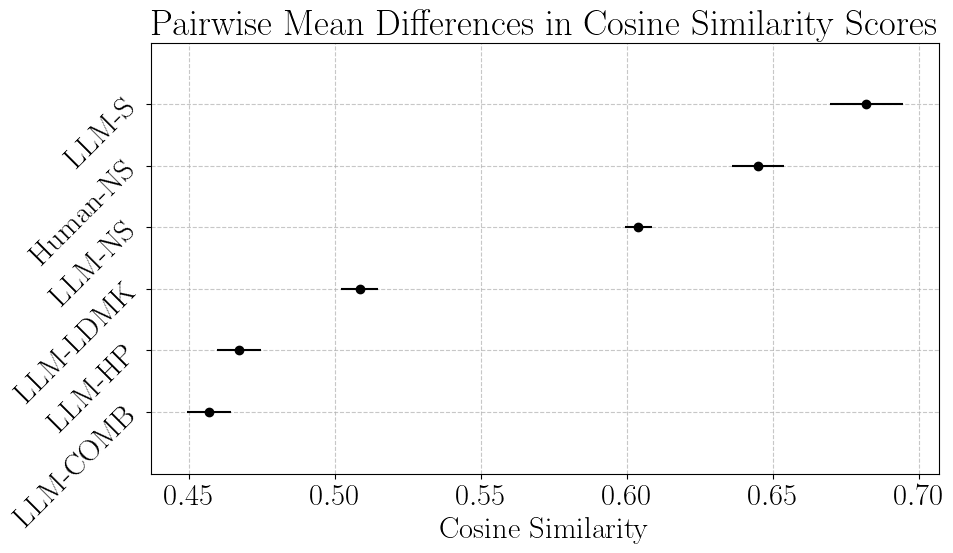

In [9]:
# Plot the results.
plt.figure(figsize=(10, 6))
plt.scatter(
    similarity_results_stats["Mean"],
    similarity_results_stats["Group"],
    color="black"
)

# Plot vertical lines for confidence intervals.
for _, row in similarity_results_stats.iterrows():
    plt.hlines(
        y=row["Group"], xmin=row["Lower"], xmax=row["Upper"], color="black"
    )

# Add plot labels.
plt.title("Pairwise Mean Differences in Cosine Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylim(-1, len(similarity_results_stats))
plt.yticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot as a PGF file.
plt.savefig("pgf/semantic_similarity_scatter_plot.pgf")

## Box Plot of Semantic Similarity Scores Across Groups

This section creates a box plot to visualize the distribution of cosine similarity scores for each annotation group. The box plot provides insights into the variability and central tendency of similarity scores across groups.

### Steps in the Visualization

1. **Creating the Box Plot:**
   - The box plot is generated using `seaborn.boxplot` with the following parameters:
     - **`x="Group"`:** Group names are displayed on the x-axis.  
     - **`y="Similarity"`:** Cosine similarity scores are displayed on the y-axis.  
     - **`hue="Group"`:** Groups are visually distinguished using different shades in the "Greys" palette.  

2. **Customizing the Plot:**
   - **Figure Size:** Set to `(10, 8)` for better readability.  
   - **Title:** "Semantic Similarity Scores Across Description Groups".  
   - **Legend:** Disabled to simplify the visualization.  
   - **X-axis Label:** Removed for a cleaner look.  

3. **Adjusting Layout and Displaying the Plot:**
   - The layout is tightened using `plt.tight_layout()` to prevent overlap and ensure all elements are clearly visible.

4. **Saving the Plot:**
   - The plot is saved as a PGF file (`pgf/semantic_similarity_box_plot.pgf`) for inclusion in LaTeX documents or further analysis.

### Importance
The box plot provides:
- A detailed view of the distribution of similarity scores within each group.  
- Key statistical features such as medians, interquartile ranges, and potential outliers.  
- A visual comparison of the consistency and quality of annotations across groups.

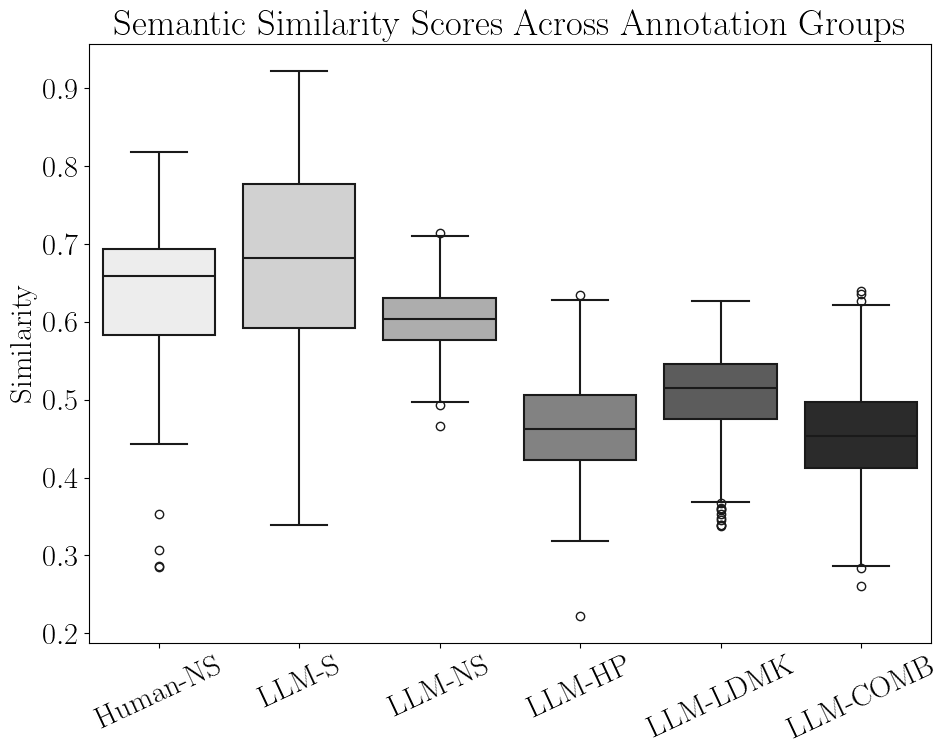

In [10]:
plt.figure(figsize=(10, 8))
sns.boxplot(
    data=df_similarity_results, x="Group", y="Similarity",
    hue="Group", palette="Greys", linewidth=1.5, legend=False
)
plt.title("Semantic Similarity Scores Across Annotation Groups")
plt.xticks(rotation=25)
plt.xlabel(None)
plt.tight_layout()

# Save the plot as a PGF file.
plt.savefig("pgf/semantic_similarity_box_plot.pgf")

## Evaluation of Hand Gesture Recognition Accuracy

This section evaluates hand gesture recognition accuracy in the UCP context.

### Analysis Overview
- The analysis focuses on calculating the recognition accuracy of various hand gesture commands.
- Commands are grouped by their annotation source.

### Objectives
This evaluation aims to:
1. Examine the impact of annotation type on gesture recognition accuracy.
2. Highlight how contextual specificity influences recognition performance.

In [11]:
# Create a dictionary of datasets.
datasets = {
    group.name: pd.read_csv(
        f"./data/predictions/{group.value}_predictions.csv"
    ) for group in Group
}

# Load the ground truth dataset.
df_ground_truth = pd.read_csv(
    f"./dataset/ground_truth_commands.csv"
)

## Calculating Recognition Accuracy Across Hand Gestures and Description Groups

This section evaluates hand gesture recognition accuracy by calculating the alignment between predicted commands and ground truth labels. The analysis is performed across different gestures and annotation groups.

### Steps in the Analysis

1. **Initialize Accuracy Results:**
   - An empty list, `accuracy_results`, is created to store the accuracy scores for each combination of group and gesture.

2. **Iterate Through Groups:**
   - For each annotation group (`group`) in the dataset:  
      - A DataFrame is created by reshaping predictions and ground truth values into a consistent long format using the `melt` function.

3. **Filter Valid Predictions:**
   - Predictions and ground truth values are filtered to exclude missing values (`notna`), ensuring valid comparisons.

4. **Iterate Over Gestures:**
   - For each gesture in the `Gesture` enum:
     - Predictions and ground truth values are filtered for the current gesture.
     - Accuracy is calculated using the `calculate_accuracy` function by comparing normalized strings (converted to lowercase and stripped of whitespace).

5. **Store Accuracy Results:**
   - Accuracy values, along with their corresponding group and gesture, are appended to the `accuracy_results` list.

6. **Convert to DataFrame:**
   - The results are converted into a pandas DataFrame (`df_accuracy_results`) for further analysis and visualization.

### Key Details
- **Gesture-Level Analysis:** Accuracy is computed for each gesture, enabling a detailed comparison of performance across commands.
- **Annotation Group Comparison:** The analysis considers how annotation source impacts recognition accuracy.

### Importance
This process provides a granular understanding of how gesture recognition systems perform across gestures and annotation groups, enabling informed improvements to recognition models.

In [12]:
# Initialize the accuracy results.
accuracy_results = []

# Calculate recognition accuracy for each gesture and group.
for group, dataset in datasets.items():

    # Create a DataFrame with a sample of predictions and ground truth.
    predictions = dataset.melt(
        id_vars="id_video", var_name="Gesture", value_name="Prediction"
    )

    size = dataset.shape[0]
    ground_truth = df_ground_truth.iloc[:size].melt(
        id_vars="id_video", var_name="Gesture", value_name="GroundTruth"
    )

    # Extract hand gesture commands.
    indexes = predictions.Prediction.notna()
    predictions = predictions[indexes]
    ground_truth = ground_truth[indexes]

    # Iterate over the gestures.
    for gesture in Gesture:

        # Filter data for the current gesture.
        prediction_data = predictions[
            predictions.Gesture == gesture.value]
        ground_truth_data = ground_truth[
            ground_truth.Gesture == gesture.value]

        # Calculate accuracy
        accuracy, correct, incorrect = calculate_accuracy(
            prediction_data.Prediction.str.lower().str.strip(),
            ground_truth_data.GroundTruth.str.lower().str.strip()
        )

        accuracy_results.append({
            "Group": group,
            "Gesture": gesture.name,
            "Accuracy": accuracy,
            "Correct": correct,
            "Incorrect": incorrect
        })

# Convert results to a DataFrame for analysis.
df_accuracy_results = pd.DataFrame(accuracy_results)

## Statistical Analysis of Gesture Recognition Accuracy

This section performs statistical tests to evaluate differences in recognition accuracy across gestures and annotation groups. Two types of tests are conducted: Chi-Square tests for overall comparisons and pairwise Proportions Z-Tests for detailed group comparisons.

### Steps in the Analysis

#### 1. Initialize Results Storage
- Two lists, `chi_square_results` and `pairwise_results`, are initialized to store the results of the Chi-Square tests and pairwise comparisons, respectively.

#### 2. Perform Chi-Square Tests
- For each gesture:
  - **Observed Data:** Accuracy counts (`Correct` and `Incorrect`) are extracted from the dataset for each annotation group.
  - **Chi-Square Test:**  
    - Evaluates whether there are significant differences in accuracy distributions across annotation groups.  
    - Test statistics (`Chi2`) and p-values are computed and stored in `chi_square_results`.

#### 3. Perform Pairwise Proportions Z-Tests
- Pairwise comparisons are conducted between all annotation groups for each gesture:
  - **Counts and Observations:**  
    - Correct predictions and total observations are extracted for each pair of groups.  
  - **Proportions Z-Test:**  
    - Tests whether the proportion of correct predictions differs significantly between two groups.  
  - Results, including Z-statistics and p-values, are appended to `pairwise_results`.

#### 4. Adjust for Multiple Comparisons
- Bonferroni correction is applied to the p-values from pairwise comparisons to account for multiple hypothesis testing:
  - Corrected p-values are added to the results for interpretation.

#### 5. Convert Results to DataFrames
- The results of both tests are converted into pandas DataFrames:
  - `df_chi_square_results`: Stores overall Chi-Square test results.  
  - `df_accuracy_pairwise_results`: Stores pairwise Proportions Z-Test results.

#### 6. Rename for Readability
- Gestures and groups are mapped to their human-readable names using dictionaries (`GESTURES_MAP` and `GROUPS_MAP`) for better interpretability.

#### 7. Save Results to CSV
- **Chi-Square Test Results:** Saved to `outputs/accuracy_chi_square_results.csv`.  
- **Pairwise Comparisons:** Saved to `outputs/accuracy_pairwise_results.csv`.

### Importance
- **Chi-Square Tests:** Provide an overall assessment of differences in recognition accuracy across groups.  
- **Pairwise Proportions Z-Tests:** Identify specific group pairs with significant differences, offering deeper insights into recognition performance variations.  
- **Bonferroni Correction:** Ensures statistical rigor when making multiple comparisons.

This analysis facilitates a detailed and statistically sound evaluation of how annotation type impact gesture recognition accuracy.

In [13]:
# Initialize statistical results.
chi_square_results = []
pairwise_results = []

for gesture in Gesture:

    # Initialize observed data.
    observed_data = np.array(
        df_accuracy_results[
            df_accuracy_results.Gesture == gesture.name
        ][["Correct", "Incorrect"]].values.tolist()
    )

    # Perform Chi-Square Test.
    chi2, p_value, _, _ = chi2_contingency(observed_data, correction=False)

    # Store overall test results.
    chi_square_results.append({
        "Gesture": gesture.name,
        "Chi2": chi2,
        "p-value": p_value
    })

    # Pairwise comparisons using Proportions Z-Test.
    for i, group1 in enumerate(Group):
        for j, group2 in enumerate(Group):
            if i >= j:
                continue

            # Extract observed data for the groups.
            count = np.array([
                observed_data[i][0], observed_data[j][0]
            ])
            nobs = np.array([
                observed_data[i].sum(), observed_data[j].sum()
            ])

            # Perform the test only if there are correct predictions.
            if count.max() > 0:
                zstat, p_value = proportions_ztest(count, nobs)
                pairwise_results.append({
                    "Gesture": gesture.name,
                    "Group1": group1.name,
                    "Group2": group2.name,
                    "Z-Stat": zstat,
                    "p-value": p_value
                })

# Adjust p-values for multiple comparisons.
pairwise_p_values = [ result["p-value"] for result in pairwise_results ]
_, corrected_p_values, _, _ = multipletests(
    pairwise_p_values, method="bonferroni")

for result, corrected_p_value in zip(pairwise_results, corrected_p_values):
    result["Corrected p-value"] = corrected_p_value

# Convert results to DataFrames.
df_chi_square_results = pd.DataFrame(chi_square_results)
df_accuracy_pairwise_results = pd.DataFrame(pairwise_results)

# Rename the DataSets for better readability.
for df in [
    df_accuracy_results,
    df_chi_square_results,
    df_accuracy_pairwise_results
]:
    df.Gesture = df.Gesture.map({
        gesture.name: GESTURES_MAP[gesture] for gesture in Gesture
    })

df_accuracy_results.Group = df_accuracy_results.Group.map({
    group.name: GROUPS_MAP[group] for group in Group
})

for column in df_accuracy_pairwise_results.columns[1:3]:
    df_accuracy_pairwise_results[column] = \
        df_accuracy_pairwise_results[column].map({
            group.name: GROUPS_MAP[group] for group in Group
        })

# Save the accuracy results statistics.
df_accuracy_results.to_csv(
    "outputs/accuracy_results.csv", index=False)
df_chi_square_results.to_csv(
    "outputs/accuracy_chi_square_results.csv", index=False)
df_accuracy_pairwise_results.to_csv(
    "outputs/accuracy_pairwise_results.csv", index=False)

## Summarizing Significant Pairwise Comparisons of Recognition Accuracy

This section filters and summarizes statistically significant differences in gesture recognition accuracy identified through pairwise Proportions Z-Tests. The results provide a clear overview of the gestures where significant differences were observed.

### Steps in the Analysis

#### 1. Filter Significant Comparisons
- From the pairwise comparison results (`df_accuracy_pairwise_results`), only those with a corrected p-value less than 0.05 are considered statistically significant.
- The filtered results are stored in `df_significant_pairwise_results`.

#### 2. Count Significant Comparisons
- Significant comparisons are grouped by `Gesture`.
- The count of significant comparisons for each combination is computed and stored in `df_pairwise_summary`.

#### 3. Create a Pivot Table
- A pivot table is created to reorganize the data for better readability:
  - **Index:** Gestures.  
  - **Columns:** UCP Context.
  - **Values:** Count of significant comparisons.  
- Missing values in the pivot table are replaced with `0`.

#### 4. Add Total Column
- A `Total` column is added to the pivot table, representing the sum of significant comparisons across the UCP context for each gesture.

#### 5. Reorder Rows
- **Rows:** Ordered by the gesture names from `GESTURES_MAP`.  

#### 6. Save Results
- The summarized pivot table (`df_accuracy_pairwise_summary`) is saved to `outputs/accuracy_pairwise_summary.csv`.
- The full filtered significant results (`df_significant_pairwise_results`) are saved to `outputs/accuracy_pairwise_results.csv`.

### Importance
- **Significant Comparisons:** Highlights gestures with meaningful differences in recognition accuracy between groups.
- **Summary Table:** Provides a clear and concise overview of significant findings across gestures.
- **Total Column:** Quantifies the overall significance level for each gesture, offering a broader perspective on its performance variability.

This step distills the results of statistical tests into actionable insights, facilitating a focused interpretation of recognition accuracy differences.

In [14]:
# Filter for significant comparisons.
df_significant_pairwise_results = df_accuracy_pairwise_results[
    df_accuracy_pairwise_results["Corrected p-value"] < 0.05
]

# Group by gesture, count significant comparisons.
df_pairwise_summary = df_significant_pairwise_results.groupby(
    ["Gesture"]
).size().reset_index(name="Total")

# Add missing gestures from GESTURES_MAP with Total as 0.
missing_gestures = \
    set(GESTURES_MAP.values()) - set(df_pairwise_summary["Gesture"])
for gesture in missing_gestures:
    df_pairwise_summary = pd.concat([
        df_pairwise_summary, pd.DataFrame({
            "Gesture": [gesture],
            "Total": [0]
        })
    ], ignore_index=True)

# Reorder the rows of pivot_summary by gestures_names.
df_accuracy_pairwise_summary = df_pairwise_summary.set_index("Gesture").reindex(
    GESTURES_MAP.values(), fill_value=0
).reset_index()

# Print the results.
print("Significant Pairwise Comparisons Summary:")
print(df_accuracy_pairwise_summary)

print("Significant Pairwise Comparisons:")
print(df_significant_pairwise_results)

# Save significant accuracy pairwise results.
df_accuracy_pairwise_summary.to_csv(
    "outputs/accuracy_pairwise_summary.csv", index=False)
df_significant_pairwise_results.to_csv(
    "outputs/accuracy_pairwise_results.csv", index=False)

Significant Pairwise Comparisons Summary:
              Gesture  Total
0     Increase volume     13
1     Decrease volume     11
2     Mute microphone     15
3   Unmute microphone      9
4     Turn off camera      8
5      Turn on camera      8
6  Ask for a question     11
7            End call      0
Significant Pairwise Comparisons:
                Gesture    Group1    Group2     Z-Stat       p-value  \
0       Increase volume   Human-S  Human-NS   6.390644  1.651881e-10   
1       Increase volume   Human-S     LLM-S   8.353069  6.651156e-17   
2       Increase volume   Human-S    LLM-NS  11.179488  5.138542e-29   
3       Increase volume   Human-S    LLM-HP  11.348876  7.512251e-30   
4       Increase volume   Human-S  LLM-LDMK  10.220747  1.601028e-24   
..                  ...       ...       ...        ...           ...   
130  Ask for a question  Human-NS  LLM-COMB   4.195306  2.725040e-05   
133  Ask for a question     LLM-S  LLM-LDMK   4.934166  8.049377e-07   
136  Ask for a 

## Bar Plot of Hand Gesture Recognition Accuracy

This section visualizes the recognition accuracy of hand gestures across different annotation groups and gestures using bar plots.

### Steps in the Visualization

#### 1. Create the Bar Plot
- The bar plot shows:
  - **X-axis:** Gestures.
  - **Y-axis:** Accuracy scores.
  - **Hue:** Annotation groups, distinguished by different shades of the "Greys" color palette.

#### 2. Add Labels to Bars
- Each bar represents the accuracy score of a specific gesture and group.
- Labels showing the accuracy value (formatted to two decimal places) are added to the top of each bar for clarity.

#### 3. Customize Plot Appearance
- **Y-axis Limit:** Set from `0` to `1.19` to accommodate bars and labels.
- **Spines:** The top spine is removed to create a cleaner look.

#### 4. Adjust Layout and Save the Plot
- The layout is tightened using `plt.tight_layout()` to ensure all elements are properly aligned.
- The final plot is saved as a PGF file (`pgf/hand_gesture_accuracy_bar_plot.pgf`) for inclusion in LaTeX documents.

### Importance
- **Group Comparisons:** The use of `hue` highlights differences in accuracy across annotation groups for each gesture.
- **Clarity:** Adding value labels to bars ensures the results are easy to interpret, even without referring to the data table.

This visualization provides a detailed overview of recognition accuracy, enabling insights into gesture performance across annotation groups.

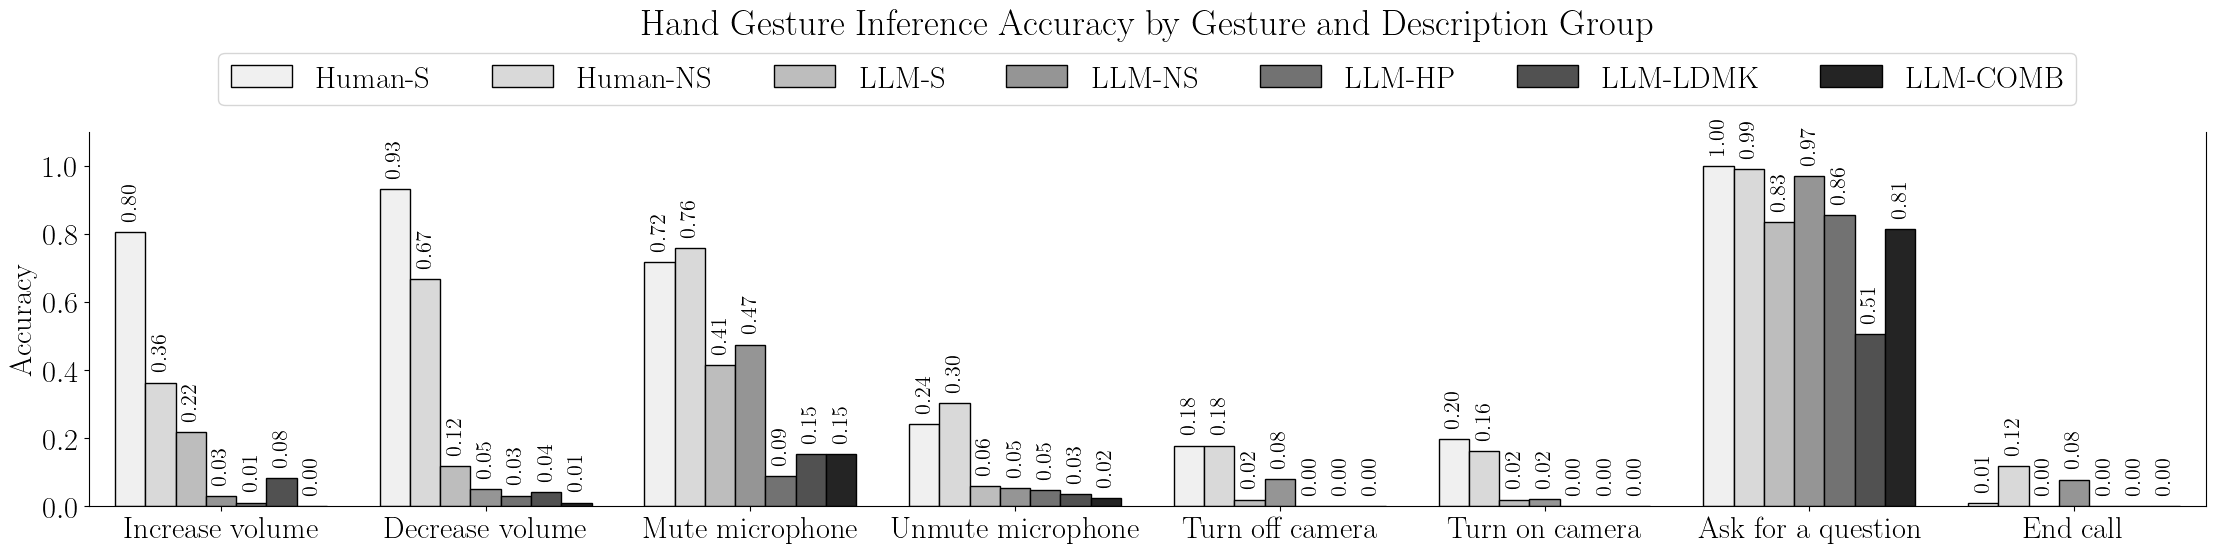

In [15]:
plt.figure(figsize=(23, 6))

# Create the bar plot with the accuracy results.
ax = sns.barplot(
    x="Gesture", y="Accuracy", hue="Group",
    data=df_accuracy_results,
    palette="Greys", edgecolor="black", dodge=True
)

# Remove the top spine.
ax.spines["top"].set_visible(False)

# Add labels to the top of each bar.
for j, bar in enumerate(ax.patches):

    # Skip the set of bars from the legend.
    if j == len(ax.patches) - len(GROUPS_MAP):
        break

    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height + 0.03,
        f"{height:.2f}", ha="center", va="bottom",
        fontsize=16, rotation=90
    )

# Add plot labels.
ax.set_title(
    "Hand Gesture Inference Accuracy by Gesture and Description Group", pad=70)
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel(None)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=7)
plt.tight_layout()

# Save the plot as a PGF file.
plt.savefig("pgf/hand_gesture_accuracy_bar_plot.pgf")